# **Architecture Description**

The method implemented in this notebook introduce a new architecture for Recurrent Neural Network that aim to solve a problem that these kind of neural networks suffer from, the exploding and vanishing gradients.

The following architecture, differently from other variants of Vanilla RNN, tries to solve these problems with the help of two components:
- a permutation matrix
- a gating mechanism

The permutation matrix is used to reflect the time dependency.
So we multiply the hidden state by a orthogonal matrix.

On the other hand the gating mechanism is agnostic to input order.
From this moment we will refer to the gating mechanism as "BLayer". See Figure a.

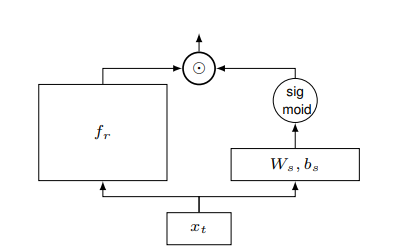
                       (a)


This BLayer is composed by two branches:

- the main one is a **Multi Layer Perceptron** (In this implementation called **left_branch**).

- The second branch contains a single **affine layer** with a **sigmoid** activation function (In this implementation called **right_branch**). See figure b.

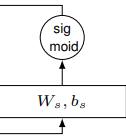
                             (b)

In this way, since the permutation matrix is an ortoghonal matrix we ensure to keep the norm of the hidden state vector, such that the gradients with respect to the hidden state do not suffer from an exponential growth or decay.

Moreover the permutation matrix doesn't have learnable parameters, so we don't increase the size of the model parameters, keeping a lighter Neural Networks w.r.t. other architectures. 



Finally we add the **BLayer** to the last hidden layer to retrieve the new hidden layer and then we apply a non-linear activation function, in this implementation we used a **ReLU**.

$$
\ h_t = \sigma(W_ph_{t-1} + b(x_t))
$$

In conclusion, the output of the network at time step t, is obtained by using a single affine layer s.

$$
\ o_t = \ s(h_t)
$$

The complete architecture is shown in Figure c.



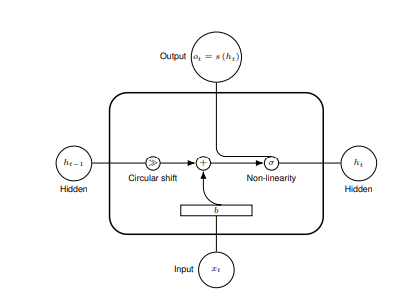
                           (c)

# **SRNN**


# **Install**

In [1]:
%%capture
!pip install torchmetrics #  install torchmetrics

# **Import Dependencies**

In [2]:
import numpy as np

import torch
import torch.nn as nn
# import torch.nn.functional as F

#used to import MNIST datatset and the transformaton to pre-precess it
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

#used to plot accuracy and loss
import matplotlib.pyplot as plt

from torchmetrics import Accuracy
# from torchmetrics import functional

from torch.utils.data import random_split, DataLoader

# **SRNN**

Here we define all the hyper parameters that we need:

We divide the image, 28x28, in a sequence of rows, each with a size of 28, so we define:


*   input_size: 28
*   sequence_length: 28

Then we have two different hidden_size:


*   MLP_hidden_size: the hidden size of the MLP hidden layer which is equal to 64
*   cell_hidden_size: the hidden size of each RNN cell which is equal to 128

Then we have:


*   Learning_rate: 0.001
*   Batch_size: 32
*   number of epcochs: 3





In [3]:
#hyper parameters
input_size = 28 #28x28
sequence_length = 28

MLP_hidden_size = 64
cell_hidden_size = 128

num_classes = 10
learning_rate = 0.001

batch_size = 32
num_epochs = 3

print_step = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


Here we implemented a simple **Multi Layer Perceptron** with just 1 hidden layer.
The activation function used is a **ReLU** and a **dropout** has been implemented between the hidden layer and the output layer with a probability of 0.2.

This will be used in the left branch of the **BLayer**.

In [4]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


Here we have the BLayer in which we use the previously defined **MLP** as left branch, and in the right branch we have a single affine layer with a sigmoid function.

In conclusion we multiply element-wise the outputs of each branch.

In [5]:
class BLayer(nn.Module):

    def __init__(self, input_size, mlp_hidden_size, output_size):
        super(BLayer, self).__init__()

        self.mlp = MLP(input_size, mlp_hidden_size, output_size)
        self.fc2 = nn.Linear(input_size, output_size)

    def forward(self, x):

        left_branch = self.mlp(x)

        right_branch = self.fc2(x)
        right_branch = torch.sigmoid(right_branch)

        b = left_branch * right_branch
        
        return b


Before to show the the final **SRNN**, here introduce an alternative way to permutate the input without applying a permutation matrix but using the native **torch.roll()** function.

# Permutation Matrix test

In [6]:
mat = []
cont = 1
for i in range(3):
  row = []
  for j in range(3):
    row.append(cont)
    cont += 1
  mat.append(row)

mat1 = torch.tensor(mat)
mat2 = torch.tensor(mat)



In [7]:
perm = torch.tensor([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0],
])

In [8]:
print(torch.matmul(mat1, perm))

tensor([[3, 1, 2],
        [6, 4, 5],
        [9, 7, 8]])


In [9]:
#permuation in the opposite direction
print(torch.roll(mat2, -1, 1))


tensor([[2, 3, 1],
        [5, 6, 4],
        [8, 9, 7]])


Here we implement the **SRNN**, which is composed by the **BLayer** and another **affine layer** that is needed to compute the output of the current cell.

In the forward step we apply the **BLayer** on the entire input, since is agnostic to the order, then we loop over the input sequence and sum it to the previous hidden layer but only after we have multiplied it by the permutation matrix.

In [10]:
class SRNN(nn.Module):

    def __init__(self, input_size, output_size, mlp_hidden_size, hidden_size):
        super(SRNN, self).__init__()

        self.bLayer = BLayer(input_size, mlp_hidden_size, hidden_size)

        self.final_fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):

        batch_size, seq_len, _ = x.shape

        b = self.bLayer(x)

        for i in range(0, seq_len):
            hidden = torch.relu(b[:, i] + torch.roll(hidden, 1, -1))
            
        outputs = hidden

        outputs = self.final_fc(outputs)
        
        return outputs, hidden


# **Dataset import and transformation**

Now we prepare the **transformations** that we will apply to the dataset and we start the download of a **MNIST** dataset.

In [11]:
customTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

mnist_full = MNIST("./", train=True, download=True, transform=customTransform)

#Here we split the dataset into training_set and validation_set
mnist_train, mnist_val = random_split(mnist_full, [55000, 5000])

mnist_test = MNIST("./", train=False, transform=customTransform)

#pain_test_split skilearn

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [14]:
#Here we split the dataset into training_set and test_set
train_data = DataLoader(mnist_train, batch_size=batch_size)
test_data = DataLoader(mnist_test, batch_size=batch_size)

In [15]:
#model init
srnn = SRNN(input_size, num_classes, MLP_hidden_size, cell_hidden_size)

In [16]:
#total model parameters 
total_params = sum(
	param.numel() for param in srnn.parameters()
)
print( total_params )

15178


In [17]:
accuracy = Accuracy(task="multiclass", num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(srnn.parameters(), lr=learning_rate)

In [18]:
n_steps = len(train_data)
losses = []
accuracies = []

In [19]:
for epoch in range(num_epochs):
    print("epoch: ", epoch)
    for i, (images, labels) in enumerate(train_data):

        images, labels = images.to(device), labels.to(device)
        
        #we have to reshape the dataset since the model expect a 3-dimensional tensor but we have a 4-dimensional
        images = images.reshape(-1, sequence_length, input_size)
        
        b_size = images.size(0)

        #we initialize the hidden for the first element in the sequence
        images = images.reshape(-1, sequence_length, input_size)
        
        b_size = images.size(0)

        hidden = torch.zeros(b_size, cell_hidden_size)

        output, hidden = srnn(images, hidden)

        output = output.reshape(-1, 10)

        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss)
        accuracies.append(accuracy(output, labels).item())

    if epoch % 1 == 0:
      print("epoch: ", epoch, " accuracy: ", accuracy(output, labels).item())
      print("epoch: ", epoch, " loss: ", loss.item())



print("End")

epoch:  0
epoch:  0  accuracy:  0.9583333134651184
epoch:  0  loss:  0.09307350963354111
epoch:  1
epoch:  1  accuracy:  0.9583333134651184
epoch:  1  loss:  0.06570423394441605
epoch:  2
epoch:  2  accuracy:  1.0
epoch:  2  loss:  0.03966159746050835
End


0.20912913978099823

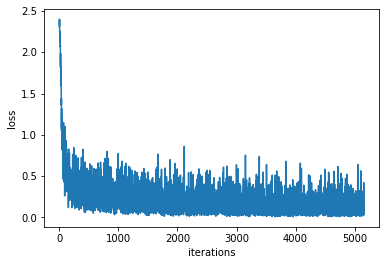

In [20]:
losses_plot = torch.tensor(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(losses_plot)
losses_plot.mean().item()

0.9359871745109558

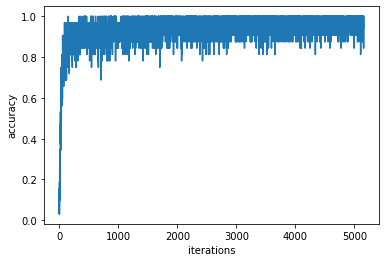

In [21]:
accuracies_plot = torch.tensor(accuracies)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.plot(accuracies_plot)
accuracies_plot.mean().item()

In [22]:
#Here we define a function to predict the values of new samples that were not in the dataset
def predict(srnn, test_data):
    losses_pred = []
    accuracies_pred = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_data):

            images = images.reshape(-1, sequence_length, input_size)
        
            b_size = images.size(0)

            hidden = torch.zeros(b_size, cell_hidden_size)

            output, hidden = srnn(images, hidden)

            output = output.reshape(-1, 10)

            loss = criterion(output, labels)


            losses_pred.append(loss.item())
            accuracies_pred.append(accuracy(output, labels).item())

            # if i % print_step == 0:
            #     print("accuracy: ", accuracy(output, labels).item())
            #     print("loss: ", loss.item())

    print("End")
    return losses_pred, accuracies_pred

In [23]:
losses_pred, accuracies_pred = predict(srnn, test_data)

End


0.1129932850599289


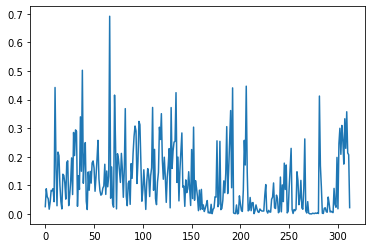

In [27]:
#Here we plot the loss and print the average of the loss
plt.plot(losses_pred)
print(torch.tensor(losses_pred).mean().item())

0.9644568562507629


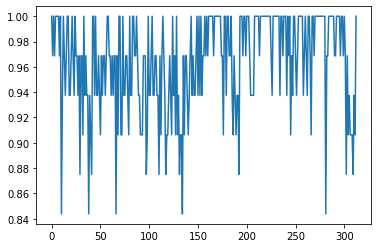

In [26]:
#Here we plot the accuracies and print the average of the accuracies
plt.plot(accuracies_pred)
print(torch.tensor(accuracies_pred).mean().item())

# **Summary**

In this implmenetation we have tested the Shuffling Neural Networks on a MNIST dataset. 

We fed the NN passing a sequence of length 28 input elements, each of this element represents a row of the image of size 28, since the initial images are 28X28.

We compared our model with a convolutional one.
We discovered that the shuffling neural network not only has challenging results but even better.

We trained both models with the same number of epochs, and the shuffling neural network showed an accuracy of 96% w.r.t. to the 92% retrieved from the convolutional one.

Moreover the convolutional one used around 170.000 parameters while the Shuffling Neural Network just around 15k.






